<h1><center>EDA and Forecasting Fraud Transactions</center></h1>
<h2><center>by Hung-Yi Chang, Yu Chen, Wenzhi Liu</center></h2>
<h3>Task and Approach:</h3>
<p>
    Many transactions are being processed every day and Payability wants to build a model to predict frauds and reject them. <br>
    We are given a list of transactions from 2018 to the present in Big Query. We are going to extract the data and preprocess it. <br>
    In order to understand better the patterns of the data, we will make use of libraries like matplotlib and seaborn. <br>
    In this notebook, we will clean the data and do exploratory data analysis (EDA) to understand the data.
</p>

In [591]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Import data
df = pd.read_csv('data/LabeledTransactions.csv')
df = df.drop(df.columns[[0]], axis = 1)
df = df.drop('acceptor_state', axis = 1)

# Convert amount to float
def s2f(s):
    return float(s.replace(",",""))
df['cc_amount'] = df['cc_amount'].apply(s2f)

<h3>Cleaning data</h3>

In [592]:
# Add new features of time derived variables
df['user_transaction_time'] = pd.to_datetime(df['user_transaction_time'], errors='coerce', utc=True)
df['hour'] = df['user_transaction_time'].dt.hour
df['month'] = df['user_transaction_time'].dt.month
df['dayofweek'] = df['user_transaction_time'].dt.dayofweek
df['year'] = df['user_transaction_time'].dt.year

# Fill in NA's
df['transaction_risk_score'] = df['transaction_risk_score'].fillna(max(df['transaction_risk_score']))
df['channel'] = df['channel'].fillna('OTHER')
df['processing_type'] = df['processing_type'].fillna('UNKNOWN')
df[['cc_amount','ledger_balance','cardholder_presence','card_presence',
    'partial_approval_capable']] = df[['cc_amount','ledger_balance','cardholder_presence','card_presence',
                                       'partial_approval_capable']].fillna(0)
df['cc_acceptor_state'] = df['cc_acceptor_state'].fillna('UNKNOWN')
df['pin_present'] = df['pin_present'].fillna(False)

# Change data types and encode cateogrical variables
cat_cols = ['channel','processing_type','cc_acceptor_state','cc_acceptor_country','cardholder_presence','card_presence',
           'partial_approval_capable','pin_present','hour','month','dayofweek','year']
print("Labels assigned to Categorical Variables\n")
for c in cat_cols:
    if c not in ['hour','month','dayofweek','year']:
        d = dict(enumerate(df[c].astype('category').cat.categories))
        print(c + ": " + str(d)+"\n")
        df[c] = df[c].astype('category').cat.codes   
    df[c] = df[c].astype('category').cat.as_ordered()
    df[c] = df[c].astype('category')
df['is_fraud'] = df['is_fraud'].astype('str')

# Remove user_transaction time
df = df.drop('user_transaction_time', axis = 1)

Labels assigned to Categorical Variables

channel: {0: 'ECOMMERCE', 1: 'MOTO', 2: 'OTHER'}

processing_type: {0: 'CARD_ON_FILE', 1: 'CHIP', 2: 'CHIP_FALLBACK', 3: 'MAGSTRIPE', 4: 'MANUAL', 5: 'UNKNOWN'}

cc_acceptor_state: {0: '12', 1: '17', 2: 'AB', 3: 'AL', 4: 'AR', 5: 'AZ', 6: 'BC', 7: 'CA', 8: 'CO', 9: 'CT', 10: 'DC', 11: 'DE', 12: 'FL', 13: 'GA', 14: 'HI', 15: 'IA', 16: 'ID', 17: 'IL', 18: 'IN', 19: 'KS', 20: 'KY', 21: 'LA', 22: 'MA', 23: 'MD', 24: 'ME', 25: 'MI', 26: 'MN', 27: 'MO', 28: 'MS', 29: 'NB', 30: 'NC', 31: 'ND', 32: 'NE', 33: 'NH', 34: 'NJ', 35: 'NL', 36: 'NM', 37: 'NS', 38: 'NV', 39: 'NY', 40: 'OH', 41: 'OK', 42: 'ON', 43: 'OR', 44: 'PA', 45: 'QC', 46: 'RI', 47: 'SC', 48: 'SD', 49: 'TN', 50: 'TX', 51: 'UNKNOWN', 52: 'UT', 53: 'VA', 54: 'VT', 55: 'WA', 56: 'WI', 57: 'WV', 58: 'WY'}

cc_acceptor_country: {0: 'AE', 1: 'AT', 2: 'AU', 3: 'BS', 4: 'CA', 5: 'CH', 6: 'CN', 7: 'CR', 8: 'CY', 9: 'CZ', 10: 'DE', 11: 'DK', 12: 'EE', 13: 'EG', 14: 'ES', 15: 'FR', 16: 'GB', 17: 'HK'

In [593]:
# Quick glimpse on the data
df.head()

,channel,transaction_risk_score,processing_type,cc_amount,ledger_balance,cc_acceptor_state,cc_acceptor_country,cardholder_presence,card_presence,partial_approval_capable,pin_present,date,is_fraud,hour,month,dayofweek,year
0,2,24.0,1,192.19,187.20,39,30,1,1,1,0,2018-12-25,0,1,12,1,2018
1,0,18.0,4,7.19,0.00,7,30,0,0,0,0,2018-12-25,0,22,12,1,2018
2,0,33.0,4,17.50,1404.67,7,30,0,0,0,0,2018-12-25,0,22,12,1,2018
3,2,32.0,1,10.00,14.66,7,30,1,1,1,0,2018-12-25,0,5,12,1,2018
4,2,26.0,3,31.33,49.95,50,30,1,1,1,0,2018-12-25,0,21,12,1,2018


In [594]:
# The data has 24443 rows and 17 columns
df.shape

(24443, 17)

In [595]:
# The data has 17 different variables (columns)
df.columns

Index(['channel', 'transaction_risk_score', 'processing_type', 'cc_amount',
       'ledger_balance', 'cc_acceptor_state', 'cc_acceptor_country',
       'cardholder_presence', 'card_presence', 'partial_approval_capable',
       'pin_present', 'date', 'is_fraud', 'hour', 'month', 'dayofweek',
       'year'],
      dtype='object')

In [596]:
# Types for each variable
df.dtypes

channel                     category
transaction_risk_score       float64
processing_type             category
cc_amount                    float64
ledger_balance               float64
cc_acceptor_state           category
cc_acceptor_country         category
cardholder_presence         category
card_presence               category
partial_approval_capable    category
pin_present                 category
date                          object
is_fraud                      object
hour                        category
month                       category
dayofweek                   category
year                        category
dtype: object

In [597]:
# Number of unique values for each variable
df.nunique(axis=0)

channel                         3
transaction_risk_score         97
processing_type                 6
cc_amount                    8638
ledger_balance              22464
cc_acceptor_state              59
cc_acceptor_country            33
cardholder_presence             2
card_presence                   2
partial_approval_capable        2
pin_present                     1
date                          269
is_fraud                        2
hour                           24
month                          12
dayofweek                       7
year                            5
dtype: int64

In [598]:
# Summarizes numeric variables
df.describe().applymap(lambda x: f"{x:0.3f}")

,transaction_risk_score,cc_amount,ledger_balance
count,24443.000,24443.000,24443.000
mean,15.571,83.602,10027.907
std,19.443,295.226,17352.258
min,1.000,0.010,-181.010
25%,3.000,14.200,532.080
50%,10.000,26.480,3270.340
75%,21.000,52.790,11134.050
max,99.000,10000.000,173250.170


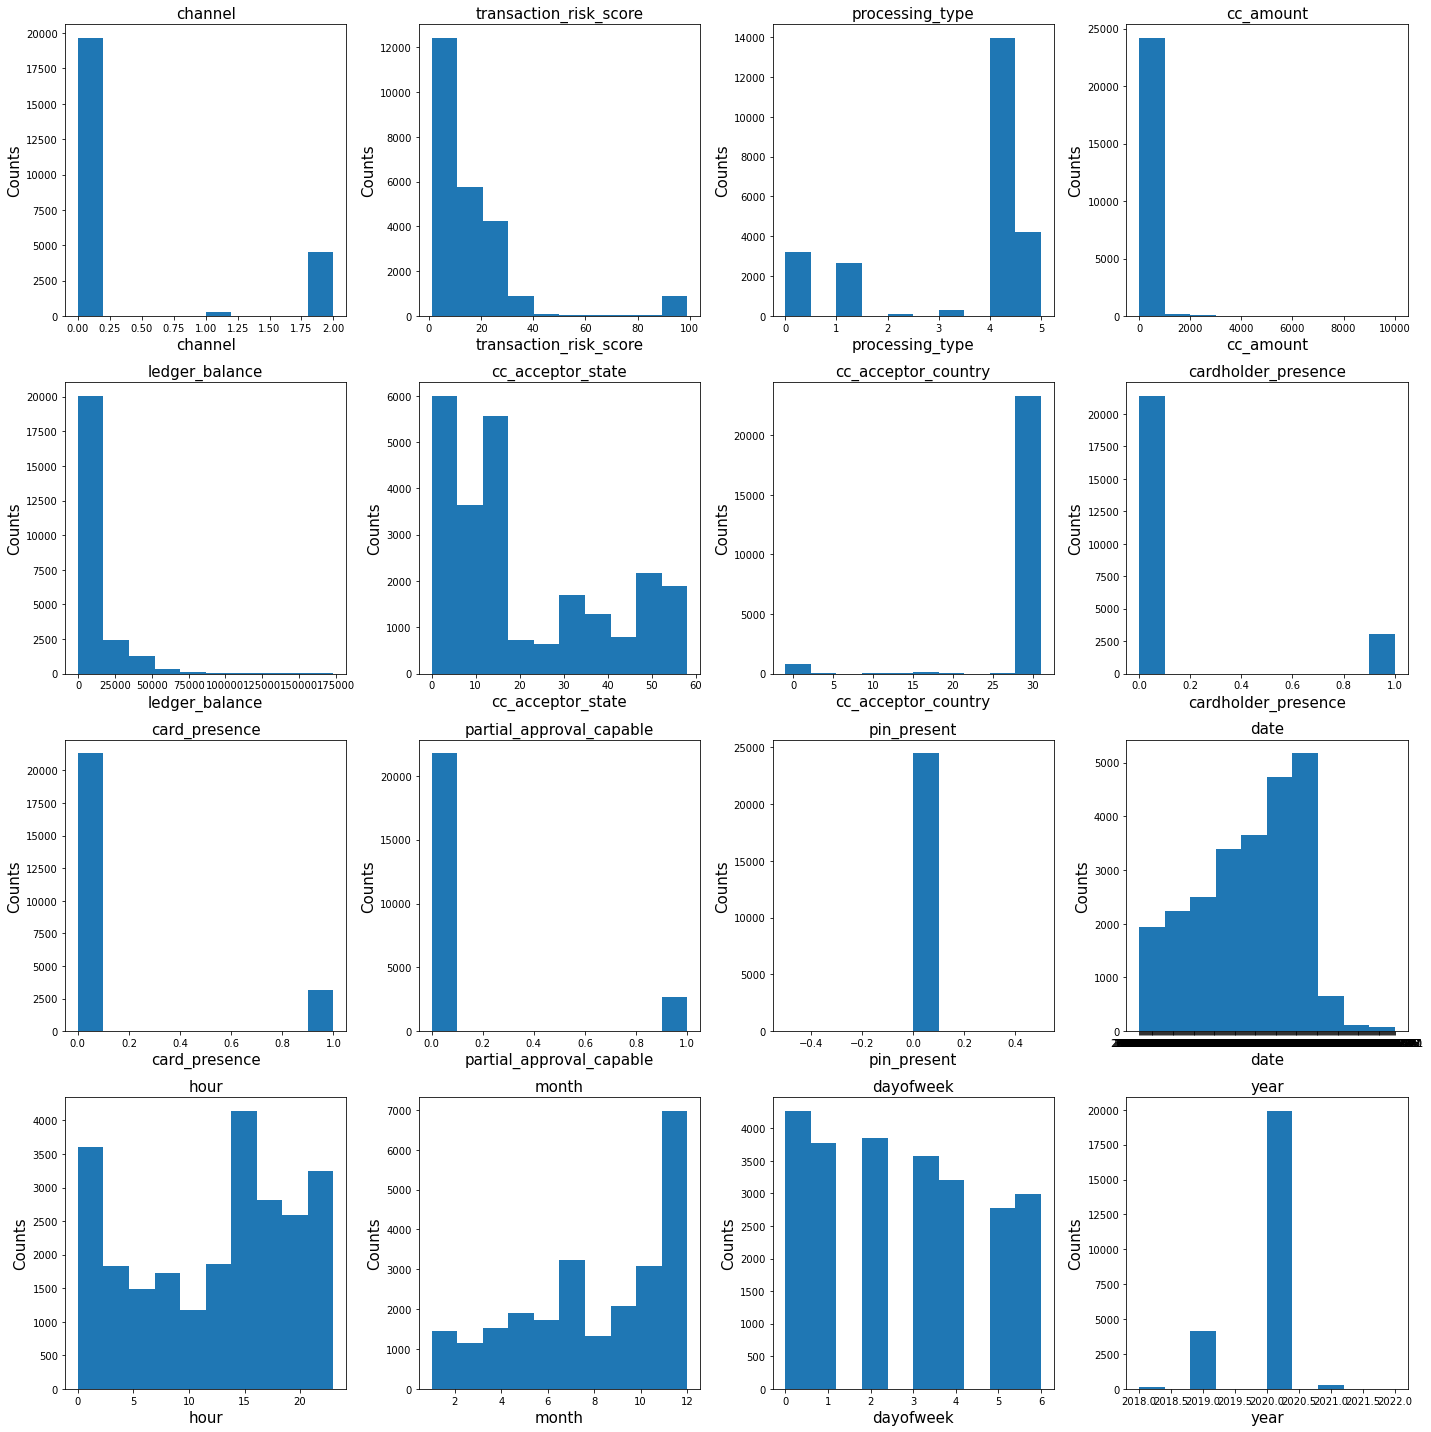

In [599]:
# Univariate distributions of all variables
var = [['channel', 'transaction_risk_score', 'processing_type', 'cc_amount'],
       ['ledger_balance', 'cc_acceptor_state', 'cc_acceptor_country','cardholder_presence'],
       ['card_presence', 'partial_approval_capable','pin_present', 'date'], 
       ['hour', 'month', 'dayofweek','year']]

fig, axs = plt.subplots(4, 4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        axs[r, c].hist(df[var[r][c]])
        axs[r, c].set_title(var[r][c], fontsize = 15)
        axs[r, c].set_xlabel(var[r][c], fontsize = 15)
        axs[r, c].set_ylabel('Counts', fontsize = 15)
        
fig.tight_layout()

### Univariate distributions Analysis
1. The most common channel is "ECOMMERCE" and the least common channel is "MOTO"
2. Most Transaction risk scores are around 0-40 and 90-100
3. The most common processing type is "MANUAL" and the least common processing type is "CHIP_FALLBACK"
4. Most transactions amount are below $1000
5. The transactions are mostly happened in the US
6. There are more transactions being processed without cardholder and card and also incapable with partial approval
7. Pins are not presented in all transaction
8. Transactions happened the most at 14-15 pm and happened the least at 9-10 am
9. Transactions happened the most in November and December and happened the least in February
10. Transactions happened the most on Monday and happened the least on Saturday
11. Most Transactions happened in 2020 and 2019

<AxesSubplot:xlabel='channel'>

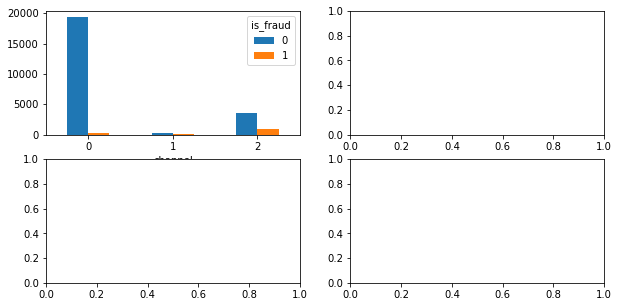

In [682]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
df1.plot.bar(rot=0,ax=axes[0,0],figsize=(10,5))

[Text(0, 0, 'ECOMMERCE'), Text(1, 0, 'MOTO'), Text(2, 0, 'OTHER')]

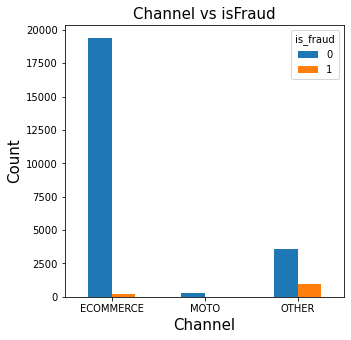

In [657]:
df1 =  pd.crosstab(df['channel'], df['is_fraud'])
ax = df1.plot.bar(rot=0,figsize=(5,5))
ax.set_xlabel('Channel',fontsize=15)
ax.set_ylabel('Count',fontsize=15)
ax.set_title('Channel vs isFraud',fontsize=15)
ax.set_xticklabels(['ECOMMERCE','MOTO','OTHER'])

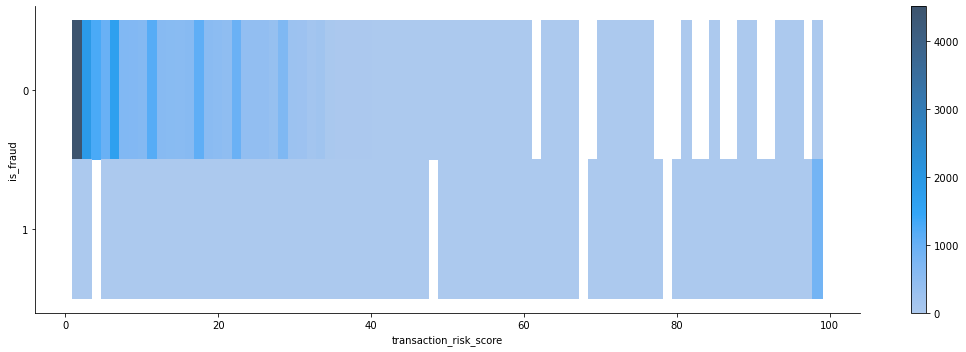

In [601]:
sns.displot(df, x="transaction_risk_score", y="is_fraud",cbar=True,height=5,aspect=3)

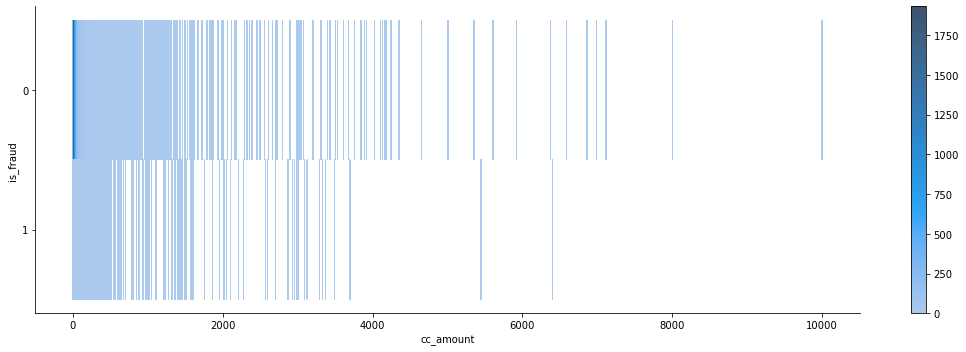

In [602]:
sns.displot(df, x="cc_amount", y="is_fraud",cbar=True,height=5,aspect=3)

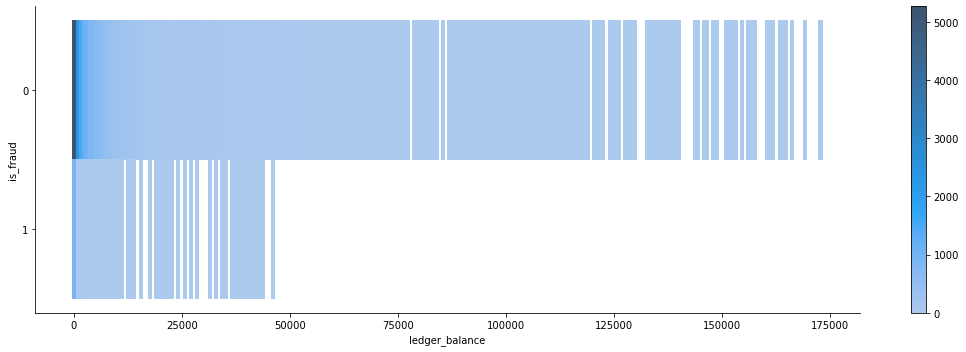

In [603]:
sns.displot(df, x="ledger_balance", y="is_fraud",cbar=True,height=5,aspect=3)